#Importing all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Loading the data

In [ ]:
data = pd.read_csv('spam.csv', encoding = "ISO-8859-1")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming columns
data.rename(columns= {"v1" : "Target", "v2" : "Text"}, inplace=True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Right now we know we have 5572 data samples beign spam or ham. Dataframe has two columns : Target and Text - both are strings.

#Data Exploration

Text(0, 0.5, 'Number of Data points')

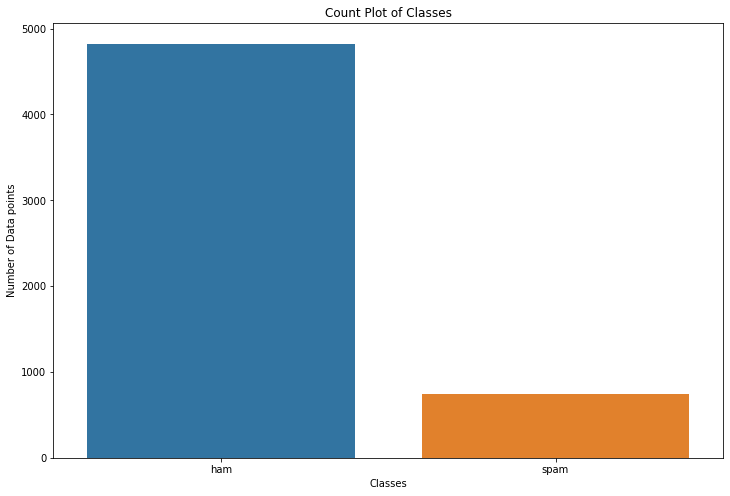

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"])
fg.set_title("Count Plot of Classes", color='black')
fg.set_xlabel("Classes")
fg.set_ylabel('Number of Data points')

So the data imbalance is quite high

#Feature Engineering

For the purpose of data exploration it's good to create some features good for text recognition
* No_of_Characters : Number of characters in the text message
* No_of_Words: Number of words in the text message
* No_of_Sentence: Number of sentences in the text message

In [ ]:
#Adding three new columns to each message
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.501256,13.637056,1.0,9.0,15.0,27.0,219.0
No_of_sentence,5572.0,1.991565,1.501427,1.0,1.0,1.5,2.0,38.0


After tokenizing I use plots to figure out where are most anomaly

<Figure size 864x576 with 0 Axes>

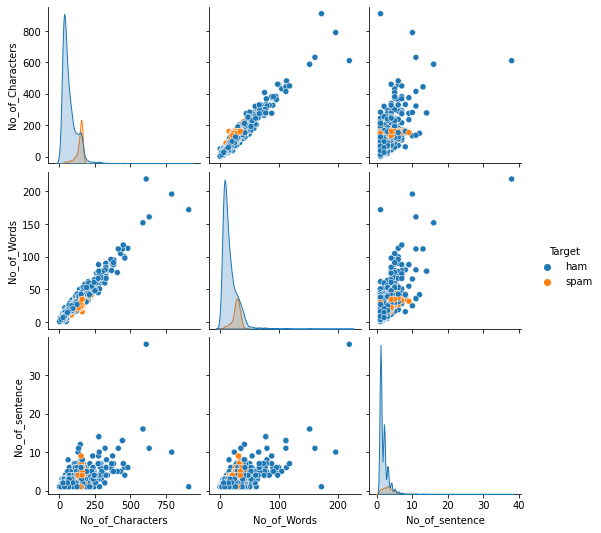

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue='Target')
plt.show(fg)

**Note:** From the pairplot we can a few outliers in the class ham. This is interesting as we cound put a cap over one of these. As they essentially indicate the same thing ie the length of SMS.
Next let's drop the outliers

In [ ]:
#Dropping the outliers
data = data[data["No_of_Characters"] < 350]
data.shape

(5548, 5)

<Figure size 864x576 with 0 Axes>

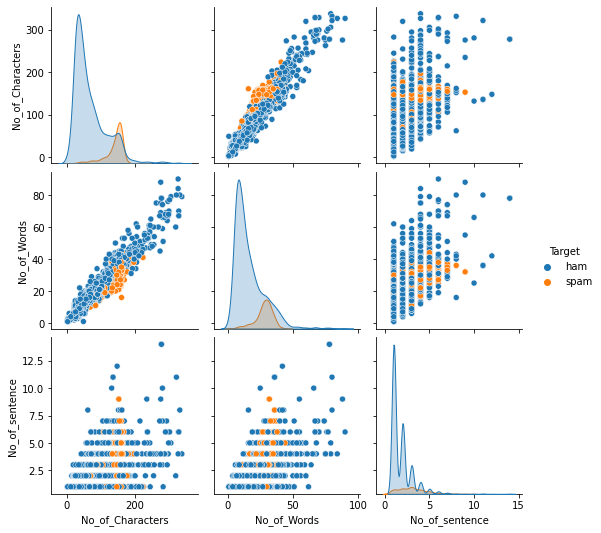

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue='Target')
plt.show(fg)

#NLP Text Preprocessing

Steps involving in preprocessing data for NLP:
* Cleaning Text
* Tokenization
* Removing Stopwords
* Lemmatization

Data cleaning in NLP is crucial. The computer doesn't understand the text for the computer, it is just a cluster of symbols. To further process the data we need to make the data cleaner. 
* In the first step we extract only the alphabetic characters by this we are removing punctuation and numbers.
* In the next step, we are converting all the characters into lowercase


This text will be then used for further preprocessing

In [ ]:
#Sample of text before cleaning
print("The first 5 Texts:",*data['Text'][:5], sep="\n")

The first 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [ ]:
# Defining function to clean up the text
def Clean(Text):
  sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non alphabetic chars with a space
  sms = sms.lower() #converting to lowercase
  sms = sms.split()
  sms = ' '.join(sms)
  return sms
data['Clean_Text'] = data['Text'].apply(Clean)
#Print some text after cleaning
print("The first 5 Texts:",*data['Clean_Text'][:5], sep="\n")

The first 5 Texts:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


**Tokenization** is breaking complex data into smaller units called tokens. It can be done by spitting paragraphs into sentences into words. I am splitting the Clean_Text into words at this step.

In [ ]:
data['Tokenize_Text'] = data.apply(lambda row: nltk.word_tokenize(row['Clean_Text']),axis=1)
print('The first 5 Texts after Tokenizing:',*data['Tokenize_Text'][:5], sep='\n')

The first 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


**Removing Stopwords** are frequently occuring words such as few, is, an ,etc. These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.

In [ ]:
#Funtion to remove stopwords
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  filtered_text = [word for word in text if word not in stop_words]
  return filtered_text
data['Nonstopword_text'] = data['Tokenize_Text'].apply(remove_stopwords)

print("The first 5 Texts after removing stopwords",*data['Nonstopword_text'][:5], sep='\n')

The first 5 Texts after removing stopwords
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


**Stemming** is the process of getting root from a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example  English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

**lemmatization** also convert's a word to its root form. However the difference is that lemmatization ensures that the root word also belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

In [ ]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
  #word_tokens = word_tokenize(text)
  lemmas = [lemmatizer.lemmatize(word, pos='v') for word in text]
  return lemmas
data['Lemmatized_Text'] = data['Nonstopword_text'].apply(lemmatize_word)
print("The first 5 texts after lemmatization:",*data['Lemmatized_Text'][:5], sep='\n')

The first 5 texts after lemmatization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


**TF-IDF** in NLP standards for Term Fequency - Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also knows as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document) / (Total number of terms in documents) Inverse Document Frequency (IDF) = log(total number of documents)/(number of documents with term t). I will be using TFidVectorizer to vectorize the preprocessed data.

**Steps in the Vectorizing:**
* Creating a corpus of lemmatized text
* Converting the corpus in vector form
* Label Encoding the classes in Target

In [ ]:
#Creating a corpus of text feature to encode further into vectorized form
corpus =[]
for i in data['Lemmatized_Text']:
  msg = ' '.join([row for row in i])
  corpus.append(msg)
corpus[:5]
print('The first 5 lines in corpus', *corpus[:5], sep='\n')

The first 5 lines in corpus
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [ ]:
#Changing text data in to numbers
tfidf  = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look to our feature
X.dtype

dtype('float64')

In [ ]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data['Target'] = label_encoder.fit_transform(data['Target'])

#Model Building

**Steps involved in the Model Building** 
* Setting up features and target as X and y
* Splitting the testing and training sets
* Build a pipeline of model for four different classifiers. (Naive Bayes, RandomForestClassifier, KNeighboursClassifier, SupportVectorMachines)
* Fill all the models on training data
* Get the cross-validation on the training set for all the models for accuracy

In [ ]:
#Setting values for labels and feature as y and X(we already did X in vectorizing)
y = data['Target']
# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
#Testing on the following classifiers
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
  cls.fit(X_train,y_train)
#Dictionary of pipelines and model types for ease of reference
pipe_dict ={0:"NaiveBayes", 1:"RandomForest", 2:"KNeighbours", 3:"SVC"}

In [ ]:
#Crossvalidation
for i, model in enumerate(classifiers):
  cv_score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
  print("%s : %f" % (pipe_dict[i], cv_score.mean()))

NaiveBayes : 0.967552
RandomForest : 0.974538
KNeighbours : 0.911450
SVC : 0.974086


#Evaluating models

**Testing the models on Testset** 
* Accuracy Report
* Confusion Matrix

In [ ]:
#creating lists of various scores
precision = []
recall = []
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
  pred_train = i.predict(X_train)
  pred_test = i.predict(X_test)
  prec = metrics.precision_score(y_test, pred_test)
  recal = metrics.recall_score(y_test, pred_test)
  f1_s = metrics.f1_score(y_test, pred_test)
  train_accuracy = model.score(X_train, y_train)
  test_accuracy = model.score(X_test, y_test)

  #Appending scores
  precision.append(prec)
  recall.append(recal)
  f1_score.append(f1_s)
  trainset_accuracy.append(train_accuracy)
  testset_accuracy.append(test_accuracy)

In [ ]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [ ]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.823529,0.903226,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


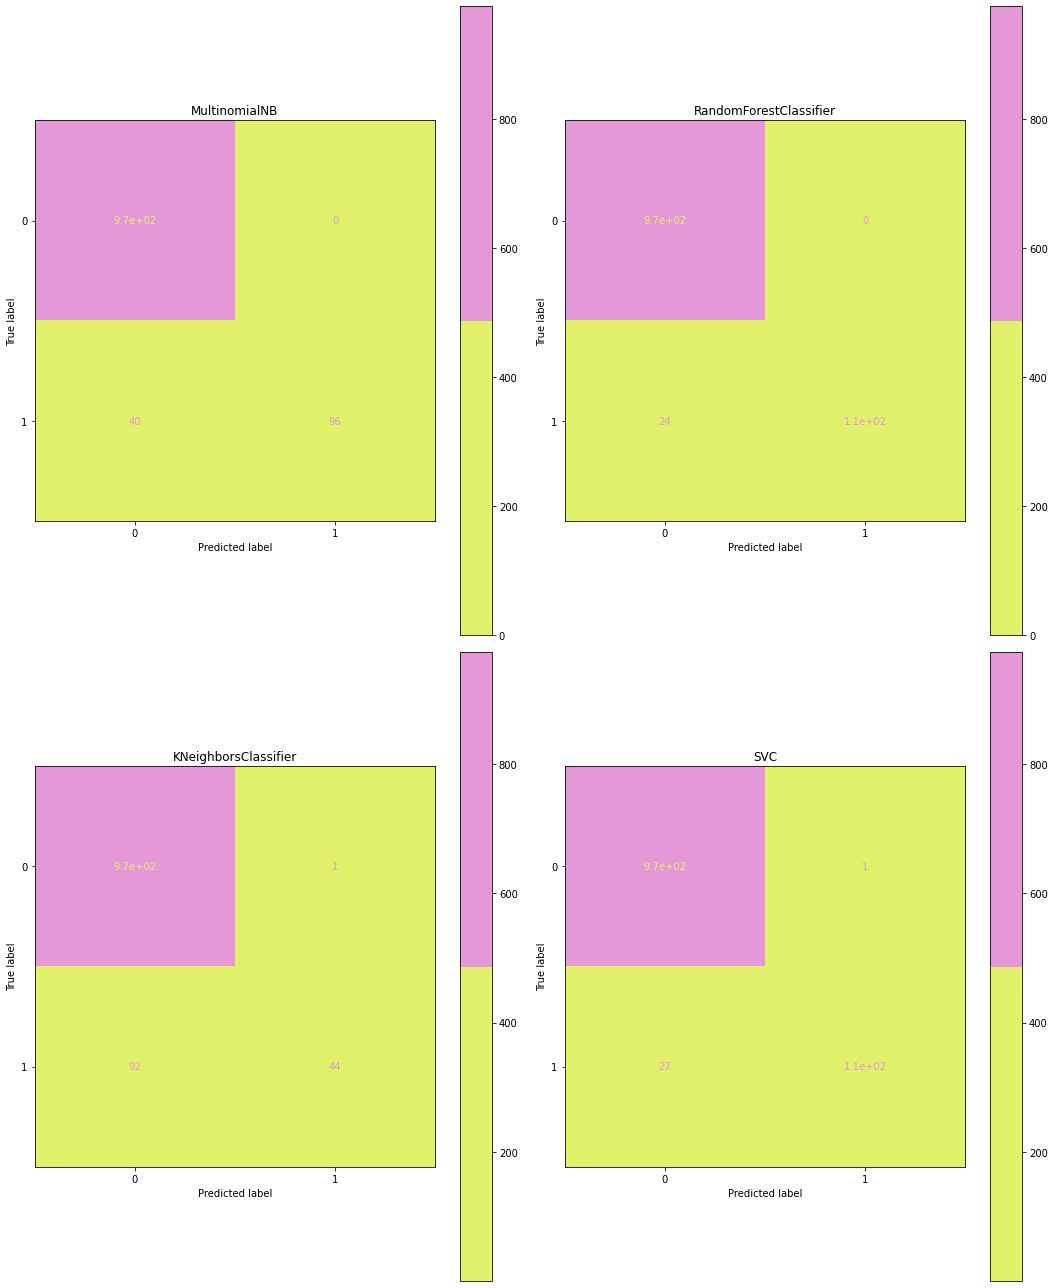

In [ ]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,18))
for cls, ax in zip(classifiers, axes.flatten()):
  plot_confusion_matrix(cls,
                        X_test,
                        y_test,
                        ax=ax,
                        cmap=cmap,)
  ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

Definitely RandomForestClassifier do the best job with classifing spam messages.